# German Political Speeches Sentiment Analysis
#### Riley Hesbacher
This Jupyter Notebook includes all work for all progress reports, so some things have been updated since progress report 1.

## Data Collection and Addition

The data I use below is under the license linked here: https://github.com/Data-Science-for-Linguists-2024/German-Political-Speeches-Sentiment-Analysis/blob/main/data-samples/LICENSE.txt

The data was originally from: 

Barbaresi, Adrien (2018). A corpus of German political speeches from the 21st century, Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018), European Language Resources Association (ELRA), pp. 792–797.

For my data, I started by taking the xml files from my corpus and turning them into dataframes for easier use. Then, I looked through the data for missing values, getting a feel for the data, etc. Then I added values to the data and dropped unnecessary sections. I started some analysis of the sentiment across parties and offices, then began the process of topic clustering.

In [1]:
#Import all the necessary libraries
import pandas as pd
import nltk
import spacy
from spacy_sentiws import spaCySentiWS
from  spacy.lang.de.stop_words import STOP_WORDS
import statistics
import numpy as np
import matplotlib.pyplot as plt
import sklearn              
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import scipy
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
#reading in the files
f = open("data/Bundespräsidenten.xml", "r")
BundesPr = pd.read_xml(f)
BundesPr.head()

,person,titel,datum,ort,untertitel,url,anrede,rohtext
0,Joachim Gauck,Begegnungsreise mit dem Diplomatischen Korps,2016-05-02,Saarbrücken,Bundespräsident Joachim Gauck hat am 2. Mai be...,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,Wie viele Botschafterinnen und Botschafter hab...
1,Joachim Gauck,Empfang des slowakischen Präsidenten,2014-02-26,Schloss Bellevue,Bundespräsident Joachim Gauck hat am 26. Febru...,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,"Besuche sind eine schöne Gelegenheit, Gemeinsa..."
2,Horst Köhler,Grußwort von Bundespräsident Horst Köhler an d...,2009-03-13,Madrid,NaN,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,"Majestät, ich danke Ihnen für Ihre Worte des M..."
3,Joachim Gauck,Gedenkkonzert des Brandenburgischen Staatsorch...,2013-11-09,NaN,Der Bundespräsident hat am 9. November bei ein...,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,Wir wollen heute Abend gedenken. Wir gedenken ...
4,Horst Köhler,Grußwort von Bundespräsident Horst Köhler bei ...,2009-12-06,Berlin,NaN,http://www.bundespraesident.de/SharedDocs/Rede...,NaN,Herzlich willkommen in Schloss Bellevue. Meine...


I can already see that some colums have NaN values, but on the surface, it's none of the columns I'm concerned with. Let's check them all to make sure.

In [3]:
BundesPr.count()

person        2045
titel         2045
datum         2045
ort           1774
untertitel     609
url           2045
anrede         224
rohtext       2045
dtype: int64

So we can see that 3 columns have NaN values. They are 'ort'(place), 'untertitel'(subtitle/decription), and 'anrede'(address). None of these are the columns I'm concerned with for my analysis, so at least for now, I will be leaving them as is. 
Lets look at the other files!

In [4]:
f = open("data/Bundesregierung.xml", "r")
BundesReg = pd.read_xml(f)
BundesReg.head()

,person,titel,datum,untertitel,url,anrede,rohtext,ort
0,Gerhard Schröder,Rede des Bundeskanzlers zur Eröffnung der 52. ...,2002-02-06,"Man kann diese Filmfestspiele nicht eröffnen, ...",http://archiv.bundesregierung.de/bpaexport/red...,"Sehr geehrte Frau Nair, liebe Mitglieder der J...","es ist angekündigt worden, man sollte im Beruf...",None
1,Julian Nida-Rümelin,Redebeitrag von Staatsminister Nida-Rümelin in...,2002-02-01,"""Ich bin der Auffassung, wir müssen nicht nur ...",http://archiv.bundesregierung.de/bpaexport/red...,Meine sehr geehrten Damen und Herren!,"Frau Präsidentin! An Sie gerichtet, Herr Börn...",None
2,Gerhard Schröder,Interview mit Bundeskanzler Schröder in 'Berli...,2002-04-14,In dem Interview äußert sich Bundeskanzler Sch...,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Frage (Peter Hahne): Bevor wir uns über den Au...,None
3,Gerhard Schröder,Rede von Bundeskanzler Gerhard Schröder bei de...,2005-03-08,Der Kampf gegen die Arbeitslosigkeit ist eine ...,http://archiv.bundesregierung.de/bpaexport/red...,Herr Ministerpräsident! Lieber Herr Dr. Bernot...,"Einen Satz von Ihnen, Herr Dr. Bernotat, habe ...",None
4,Gerhard Schröder,Rede von Bundeskanzler Gerhard Schröder auf de...,2000-05-04,NaN,http://archiv.bundesregierung.de/bpaexport/red...,"Sehr geehrter Herr Professor Landfried, sehr ...",diese Jahresversammlung der Hochschulrektorenk...,None


In [5]:
f = open("data/Bundestagspräsidenten.xml", "r")
BTagPr = pd.read_xml(f)
BTagPr.head()

,person,titel,datum,ort,untertitel,url,anrede,rohtext
0,Norbert Lammert,Deutscher Bundestag - Laudatio zur Verleihung ...,2011-02-12,NaN,NaN,https://www.bundestag.de/parlament/praesidium/...,NaN,"""Der du von dem Himmel bist,Alle Freud und Sch..."
1,Norbert Lammert,Deutscher Bundestag - Rede des Bundestagspräsi...,2009-01-13,NaN,NaN,https://www.bundestag.de/parlament/praesidium/...,NaN,"Sehr geehrter Herr Vorsitzender, lieber Peter ..."
2,Norbert Lammert,Deutscher Bundestag - Rede des Bundestagspräsi...,2009-10-27,NaN,NaN,https://www.bundestag.de/parlament/praesidium/...,NaN,Sehr geehrter Herr Bundespräsident! Verehrte G...
3,Norbert Lammert,Rede anlässlich der Entgegennahme des Georg-S...,17. November 2011,NaN,NaN,NaN,NaN,"Sehr geehrter Herr Präsident, lieber Wolfgang ..."
4,Norbert Lammert,Deutscher Bundestag - Rede des Bundestagspräsi...,2007-01-29,NaN,NaN,https://www.bundestag.de/parlament/praesidium/...,NaN,Sehr geehrter Herr Bundespräsident!Verehrte Fr...


In [6]:
f = open("data/AuswärtigesAmt.xml", "r")
AusAmt = pd.read_xml(f)
AusAmt.head()

,person,titel,datum,ort,untertitel,url,anrede,rohtext
0,Cornelia Pieper,"Rede Staatsministerin Pieper: ""150 Jahre Wisse...",2010-10-14,NaN,"""150 Jahre Wissenschaftsbeziehungen Deutschlan...",http://www.auswaertiges-amt.de/DE/Infoservice/...,"Sehr geehrter Herr Präsident Kajiyama,meine Da...",Ich freue mich sehr über den warmherzigen Empf...
1,Cornelia Pieper,Rede von Staatsministerin Cornelia Pieper im D...,2011-06-30,NaN,Rede von Staatsministerin Cornelia Pieper im D...,http://www.auswaertiges-amt.de/DE/Infoservice/...,Liebe Kolleginnen und Kollegen!,"Ich begrüße es, dass wir heute über die weiter..."
2,Guido Westerwelle,Rede von Guido Westerwelle im Deutschen Bundes...,2010-05-21,NaN,Rede von Bundesaußenminister Guido Westerwelle...,http://www.auswaertiges-amt.de/DE/Infoservice/...,NaN,"Frau Präsidentin!\nHerr Kollege Gabriel, Ihre ..."
3,Frank-Walter Steinmeier,Rede von Außenminister Steinmeier anlässlich d...,2014-11-15,NaN,Rede von Außenminister Steinmeier anlässlich d...,http://www.auswaertiges-amt.de/DE/Infoservice/...,"Sehr geehrte Damen und Herren,",ich sage Dank für die Einladung und habe Respe...
4,Guido Westerwelle,Rede von Außenminister Westerwelle vor der Ver...,2010-11-02,NaN,Rede von Außenminister Westerwelle vor der Ver...,http://www.auswaertiges-amt.de/DE/Infoservice/...,"Sehr geehrte Damen und Herren,",zunächst möchte ich mich sehr herzlich bei Ihn...


I would like to merge all of these dataframes, so I can look at the patterns accross them all, but I do want to know which they came from to keep track. So I'm going to add a column for 'amt'(government office) to mark the file origin of the speaker which is based on what office they are from. 

In [7]:
BundesPr.insert(7, "amt", "Bundespräsident")
BTagPr.insert(7, "amt", "Bundestagspräsident")
AusAmt.insert(7, "amt", "AuswärtigesAmt")
BundesReg.insert(6, "amt", "Bundesregierung")

In [8]:
BundesReg['person'].unique()

array(['Gerhard Schröder', 'Julian Nida-Rümelin', 'Christina Weiss',
       'Frank-Walter Steinmeier', 'Michael Naumann', 'Hans Martin Bury',
       'Otto Graf Lambsdorff', 'Peter Struck', 'Joschka Fischer',
       'Rolf Schwanitz', 'Waldemar Ritter', 'Edelgard Bulmahn',
       'Jürgen Trittin', 'k.A.', 'Friedrich Merz', 'Rudolf Scharping',
       'Renate Schmidt', 'Brigitte Zypries', 'Christine Bergmann',
       'Brigitte Sauzay', 'Heidemarie Wieczorek-Zeul',
       'Matthias Platzeck', 'Béla Anda', 'Werner Müller',
       'Herta Däubler-Gmelin', 'Angela Merkel', 'Bernd Neumann',
       'Ursula von der Leyen', 'Thomas de Maizière', 'Peer Steinbrück',
       'Michael Glos', 'Maria Böhmer', 'Franz Müntefering',
       'Wolfgang Schäuble', 'Franz Josef Jung', 'Sigmar Gabriel',
       'Hans Bernhard Beus', 'Hildegard Müller', 'Hermann Gröhe',
       'Ronald Pofalla', 'Joachim Gauck', 'Roman Herzog', 'Ilse Aigner',
       'Monika Grütters', 'Aydan Özoğuz', 'Helmut Kohl'], dtype=object)

I realized that some speakers are unknown, but they are not marked as NaN. Instead it's 'k.A' for 'keine Ahnung'(no idea). I decided to get rid of k.A. value rows because there arent many(only 66 across over 6000 rows), and they wont be helpful for most of my analysis. 

In [9]:
BundesReg.loc[BundesReg['person'] == 'k.A.']

,person,titel,datum,untertitel,url,anrede,amt,rohtext,ort
272,k.A.,"""Nur gemeinsam werden wir es schaffen"". Aufgab...",2000-06-09,NaN,http://archiv.bundesregierung.de/bpaexport/red...,"Sehr geehrter Herr Dr. Hanusch, sehr geehrte D...",Bundesregierung,Veranstaltung im Rahmen der evangelischen Akad...,None
378,k.A.,Das Archiv unterdrückter Literatur in der DDR,2005-04-13,Am 13. April 2005 wurde das Archiv unterdrückt...,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,am Wochenende habe ich ein Interview mit einer...,None
636,k.A.,"Rede auf dem ""Zeitungstag"" des Bundesverbandes...",1999-06-15,NaN,http://archiv.bundesregierung.de/bpaexport/red...,"Meine Damen und Herren,",Bundesregierung,"wenn ich das richtig sehe, ist dies das letzte...",None
659,k.A.,Rede anlässlich der Arbeitstagung des Goethe-I...,1999-09-27,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,Zunächst möchte ich mich ganz herzlich für die...,None
674,k.A.,Rede bei der Hypothekenbank in Essen am 8. Nov...,1999-11-08,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,Kultur in Deutschland wird von Politikern meis...,None
693,k.A.,Auf dem Weg in die Berliner Republik.Rede am 1...,1999-11-17,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,"Die kleine Bankettfrage des vorigen Herbstes, ...",None
703,k.A.,Wirtschaftliche Aspekte der Kulturpolitik bei ...,1999-11-22,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,Kultur ist der Name für alle Formen von Zweife...,None
710,k.A.,Rede anläßlich der Beiratssitzung Süd der Deut...,1999-11-29,NaN,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,ich darf mich zunächst einmal recht herzlich b...,None
860,k.A.,Auftaktveranstaltung des Deutsch-Polnischen Ja...,2005-05-08,Am 8. Mai 2005 machten die Teilnehmer an der K...,http://archiv.bundesregierung.de/bpaexport/red...,NaN,Bundesregierung,eigentlich möchte man jetzt nur noch ausrufen:...,None
1095,k.A.,Grußwort,2007-04-04,"am Mittwoch, 4. April 2007 in Torgau (Schloss ...",http://www.bundesregierung.de/nn_914560/Conten...,"Sehr verehrte Frau Bürgermeisterin, sehr geehr...",Bundesregierung,"es ist mir eine Freude, heute zu der Eröffnung...",None


In [10]:
#reordering columns for ease
BundesPr = BundesPr[['person', 'datum', 'titel', 'amt', 'url', 'rohtext', 'ort', 'untertitel', 'anrede']]
BundesReg = BundesReg[['person', 'datum', 'titel', 'amt', 'url', 'rohtext', 'ort', 'untertitel', 'anrede']]
BTagPr = BTagPr[['person', 'datum', 'titel', 'amt', 'url', 'rohtext', 'ort', 'untertitel', 'anrede']]
AusAmt = AusAmt[['person', 'datum', 'titel', 'amt', 'url', 'rohtext', 'ort', 'untertitel', 'anrede']]

In [11]:
#Let's put them all together!
speeches = pd.concat([BundesPr, BundesReg, BTagPr, AusAmt])
speeches.head()

,person,datum,titel,amt,url,rohtext,ort,untertitel,anrede
0,Joachim Gauck,2016-05-02,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,Saarbrücken,Bundespräsident Joachim Gauck hat am 2. Mai be...,NaN
1,Joachim Gauck,2014-02-26,Empfang des slowakischen Präsidenten,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...",Schloss Bellevue,Bundespräsident Joachim Gauck hat am 26. Febru...,NaN
2,Horst Köhler,2009-03-13,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...",Madrid,NaN,NaN
3,Joachim Gauck,2013-11-09,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...,NaN,Der Bundespräsident hat am 9. November bei ein...,NaN
4,Horst Köhler,2009-12-06,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,Berlin,NaN,NaN


In [12]:
#Let's delete the 'k.A.' rows
speeches = speeches.drop(speeches[speeches['person'] == 'k.A.'].index)

In [13]:
#Lets delete some unnecessary columns
speeches = speeches.drop(columns=['ort', 'untertitel','anrede'])
speeches.head()

,person,datum,titel,amt,url,rohtext
0,Joachim Gauck,2016-05-02,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...
1,Joachim Gauck,2014-02-26,Empfang des slowakischen Präsidenten,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa..."
2,Horst Köhler,2009-03-13,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M..."
3,Joachim Gauck,2013-11-09,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...
4,Horst Köhler,2009-12-06,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...


In [14]:
#Time to add the political party of each speaker
#I'm also going to add gender at the same time to save time
speeches['person'].unique()

array(['Joachim Gauck', 'Horst Köhler', 'Christian Wulff', 'Johannes Rau',
       'Roman Herzog', 'Richard von Weizsäcker', 'Gerhard Schröder',
       'Julian Nida-Rümelin', 'Christina Weiss',
       'Frank-Walter Steinmeier', 'Michael Naumann', 'Hans Martin Bury',
       'Otto Graf Lambsdorff', 'Peter Struck', 'Joschka Fischer',
       'Rolf Schwanitz', 'Waldemar Ritter', 'Edelgard Bulmahn',
       'Jürgen Trittin', 'Friedrich Merz', 'Renate Schmidt',
       'Brigitte Zypries', 'Christine Bergmann', 'Brigitte Sauzay',
       'Heidemarie Wieczorek-Zeul', 'Matthias Platzeck', 'Béla Anda',
       'Rudolf Scharping', 'Werner Müller', 'Herta Däubler-Gmelin',
       'Angela Merkel', 'Bernd Neumann', 'Ursula von der Leyen',
       'Thomas de Maizière', 'Peer Steinbrück', 'Michael Glos',
       'Maria Böhmer', 'Franz Müntefering', 'Wolfgang Schäuble',
       'Franz Josef Jung', 'Sigmar Gabriel', 'Hans Bernhard Beus',
       'Hildegard Müller', 'Hermann Gröhe', 'Ronald Pofalla',
       'Ilse A

In [15]:
# NOTE TO THE READER: I know this section looks ugly, but it's faster than putting all the party/gender info into a csv, then into a dataframe, then merging it. So unfortunately, this is where we're at. If it were much more data that would be easier to line up in a csv and just merge in by speaker, I would. 
speeches.insert(2, "partei", "")
speeches.insert(3, "gender", "")
speeches['partei'].loc[speeches['person'] == 'Joachim Gauck'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Joachim Gauck'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Horst Köhler'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Horst Köhler'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Christian Wulff'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Christian Wulff'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Johannes Rau'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Johannes Rau'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Roman Herzog'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Roman Herzog'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Richard von Weizsäcker'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Richard von Weizsäcker'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Gerhard Schröder'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Gerhard Schröder'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Julian Nida-Rümelin'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Julian Nida-Rümelin'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Christina Weiss'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Christina Weiss'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Frank-Walter Steinmeier'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Frank-Walter Steinmeier'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Michael Naumann'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Michael Naumann'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Hans Martin Bury'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Hans Martin Bury'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Otto Graf Lambsdorff'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Otto Graf Lambsdorff'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Peter Struck'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Peter Struck'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Joschka Fischer'] = 'Grünen'
speeches['gender'].loc[speeches['person'] == 'Joschka Fischer'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Rolf Schwanitz'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Rolf Schwanitz'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Waldemar Ritter'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Waldemar Ritter'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Edelgard Bulmahn'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Edelgard Bulmahn'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Jürgen Trittin'] = 'Grünen'
speeches['gender'].loc[speeches['person'] == 'Jürgen Trittin'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Friedrich Merz'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Friedrich Merz'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Renate Schmidt'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Renate Schmidt'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Brigitte Zypries'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Brigitte Zypries'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Christine Bergmann'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Christine Bergmann'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Brigitte Sauzay'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Brigitte Sauzay'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Heidemarie Wieczorek-Zeul'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Heidemarie Wieczorek-Zeul'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Matthias Platzeck'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Matthias Platzeck'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Béla Anda'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Béla Anda'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Rudolf Scharping'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Rudolf Scharping'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Werner Müller'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Werner Müller'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Herta Däubler-Gmelin'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Herta Däubler-Gmelin'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Angela Merkel'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Angela Merkel'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Bernd Neumann'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Bernd Neumann'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Ursula von der Leyen'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Ursula von der Leyen'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Thomas de Maizière'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Thomas de Maizière'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Peer Steinbrück'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Peer Steinbrück'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Michael Glos'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Michael Glos'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Maria Böhmer'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Maria Böhmer'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Franz Müntefering'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Franz Müntefering'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Wolfgang Schäuble'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Wolfgang Schäuble'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Franz Josef Jung'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Franz Josef Jung'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Sigmar Gabriel'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Sigmar Gabriel'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Hans Bernhard Beus'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Hans Bernhard Beus'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Hildegard Müller'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Hildegard Müller'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Hermann Gröhe'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Hermann Gröhe'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Ronald Pofalla'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Ronald Pofalla'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Ilse Aigner'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Ilse Aigner'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Monika Grütters'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Monika Grütters'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Aydan Özoğuz'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Aydan Özoğuz'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Helmut Kohl'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Helmut Kohl'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Norbert Lammert'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Norbert Lammert'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Wolfgang Thierse'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Wolfgang Thierse'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Cornelia Pieper'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Cornelia Pieper'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Guido Westerwelle'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Guido Westerwelle'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Andreas Schockenhoff'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Andreas Schockenhoff'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Werner Hoyer'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Werner Hoyer'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Michael Roth'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Michael Roth'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Stephan Steinlein'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Stephan Steinlein'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Michael Georg Link'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Michael Georg Link'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Gernot Erler'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Gernot Erler'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Harald Leibrecht'] = 'FDP'
speeches['gender'].loc[speeches['person'] == 'Harald Leibrecht'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Günter Gloser'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Günter Gloser'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Markus Ederer'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Markus Ederer'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Karsten D. Voigt'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Karsten D. Voigt'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Günter Nooke'] = 'CDU'
speeches['gender'].loc[speeches['person'] == 'Günter Nooke'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Christoph Strässer'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Christoph Strässer'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Dietmar Woidke'] = 'SPD'
speeches['gender'].loc[speeches['person'] == 'Dietmar Woidke'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Peter Ammon'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Peter Ammon'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Martin Kobler'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Martin Kobler'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Emily Haber'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Emily Haber'] = 'F'

speeches['partei'].loc[speeches['person'] == 'Reinhard Silberberg'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Reinhard Silberberg'] = 'M'

speeches['partei'].loc[speeches['person'] == 'Harald Braun'] = 'parteilos'
speeches['gender'].loc[speeches['person'] == 'Harald Braun'] = 'M'

In [16]:
#Tokenize words and get counts
speeches["wordToks"] = speeches.loc[:, "rohtext"].apply(lambda x: nltk.word_tokenize(x))
speeches["wordCt"] = speeches.loc[:, "wordToks"].apply(lambda x: len(x))
#Tokenize sents and get counts
speeches["sents"] = speeches.loc[:, "rohtext"].apply(lambda x: nltk.sent_tokenize(x))
speeches["sentCt"] = speeches.loc[:, "sents"].apply(lambda x: len(x))
#make bigrams and types!
speeches["bigrams"] = speeches.loc[:, "wordToks"].apply(lambda x: list(nltk.bigrams(x)))
speeches["types"] = speeches.loc[:, "wordToks"].apply(lambda x: set(x))                                                        
speeches.head() #isnt it beautiful

,person,datum,partei,gender,titel,amt,url,rohtext,wordToks,wordCt,sents,sentCt,bigrams,types
0,Joachim Gauck,2016-05-02,parteilos,M,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,"[Wie, viele, Botschafterinnen, und, Botschafte...",1653,[Wie viele Botschafterinnen und Botschafter ha...,87,"[(Wie, viele), (viele, Botschafterinnen), (Bot...","{Folge, den, rette, seien, Lösung, Denn, heißt..."
1,Joachim Gauck,2014-02-26,parteilos,M,Empfang des slowakischen Präsidenten,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...","[Besuche, sind, eine, schöne, Gelegenheit, ,, ...",833,"[Besuche sind eine schöne Gelegenheit, Gemeins...",43,"[(Besuche, sind), (sind, eine), (eine, schöne)...","{Hauptstadt, den, Monate, stehen, schönen, hei..."
2,Horst Köhler,2009-03-13,CDU,M,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...","[Majestät, ,, ich, danke, Ihnen, für, Ihre, Wo...",784,"[Majestät, ich danke Ihnen für Ihre Worte des ...",50,"[(Majestät, ,), (,, ich), (ich, danke), (danke...","{den, stehen, daher, begrüßen, Stelle, birgt, ..."
3,Joachim Gauck,2013-11-09,parteilos,M,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...,"[Wir, wollen, heute, Abend, gedenken, ., Wir, ...",821,"[Wir wollen heute Abend gedenken., Wir gedenke...",32,"[(Wir, wollen), (wollen, heute), (heute, Abend...","{den, Juden, Gute, Angst, stehen, führte, dere..."
4,Horst Köhler,2009-12-06,CDU,M,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,"[Herzlich, willkommen, in, Schloss, Bellevue, ...",1149,"[Herzlich willkommen in Schloss Bellevue., Mei...",49,"[(Herzlich, willkommen), (willkommen, in), (in...","{den, Lösung, Kurt, Stelle, Metzmacher, las, E..."


I'm going to add further values for government position to look across those variations as well. Some of them I can label quickly because the 'amt' they were sorted into was for a specific position, but for others the Amt was too general to figure out the position from that alone.

In [17]:
speeches.insert(5, "position", "")

In [18]:
speeches['position'].loc[speeches['person'] == 'Joachim Gauck'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Horst Köhler'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Christian Wulff'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Johannes Rau'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Roman Herzog'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Richard von Weizsäcker'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Gerhard Schröder'] = 'Bundeskanzler'

speeches['position'].loc[speeches['person'] == 'Julian Nida-Rümelin'] = 'Kulturstaatsminister'

speeches['position'].loc[speeches['person'] == 'Christina Weiss'] = 'Staatsminister'

speeches['position'].loc[speeches['person'] == 'Frank-Walter Steinmeier'] = 'Bundespräsident'

speeches['position'].loc[speeches['person'] == 'Michael Naumann'] = 'Kulturstaatsminister'

speeches['position'].loc[speeches['person'] == 'Hans Martin Bury'] = 'Staatsminister für Europa'

speeches['position'].loc[speeches['person'] == 'Otto Graf Lambsdorff'] = 'Bundesminister für Wirtschaft'

speeches['position'].loc[speeches['person'] == 'Peter Struck'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Joschka Fischer'] = 'Außenminister'

speeches['position'].loc[speeches['person'] == 'Rolf Schwanitz'] = 'Staatsminister'

speeches['position'].loc[speeches['person'] == 'Waldemar Ritter'] = 'Referatsleiter'

speeches['position'].loc[speeches['person'] == 'Edelgard Bulmahn'] = ' Bundesminister für Bildung und Forschung'

speeches['position'].loc[speeches['person'] == 'Jürgen Trittin'] = 'Bundesminister für Umwelt, Naturschutz und Reaktorsicherheit'

speeches['position'].loc[speeches['person'] == 'Friedrich Merz'] = 'Bundestagsabgeordneter'

speeches['position'].loc[speeches['person'] == 'Renate Schmidt'] = 'Bundesminister für Familie, Senioren, Frauen und Jugend'

speeches['position'].loc[speeches['person'] == 'Brigitte Zypries'] = 'Bundesminister der Justiz'

speeches['position'].loc[speeches['person'] == 'Christine Bergmann'] = 'Bundesminister für Familie, Senioren, Frauen und Jugend'

speeches['position'].loc[speeches['person'] == 'Brigitte Sauzay'] = 'Berater für die deutsch-französischen Beziehungen'

speeches['position'].loc[speeches['person'] == 'Heidemarie Wieczorek-Zeul'] = 'Bundesminister für wirtschaftliche Zusammenarbeit und Entwicklung'

speeches['position'].loc[speeches['person'] == 'Matthias Platzeck'] = 'Vorsitzender des Deutsch-Russischen Forums'

speeches['position'].loc[speeches['person'] == 'Béla Anda'] = 'Regierungssprecher'

speeches['position'].loc[speeches['person'] == 'Rudolf Scharping'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Werner Müller'] = 'Bundesminister für Wirtschaft und Technologie'

speeches['position'].loc[speeches['person'] == 'Herta Däubler-Gmelin'] = 'stellvertretende Vorsitzende der SPD-Bundestagsfraktion'

speeches['position'].loc[speeches['person'] == 'Angela Merkel'] = 'Bundeskanzler'

speeches['position'].loc[speeches['person'] == 'Bernd Neumann'] = 'Kulturstaatsminister'

speeches['position'].loc[speeches['person'] == 'Ursula von der Leyen'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Thomas de Maizière'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Peer Steinbrück'] = 'Bundesminister der Finanzen'

speeches['position'].loc[speeches['person'] == 'Michael Glos'] = 'Bundesminister für Wirtschaft und Technologie'

speeches['position'].loc[speeches['person'] == 'Maria Böhmer'] = 'Staatsminister für Auswärtige Kultur- und Bildungspolitik'

speeches['position'].loc[speeches['person'] == 'Franz Müntefering'] = 'Bundesminister für Arbeit und Soziales'

speeches['position'].loc[speeches['person'] == 'Wolfgang Schäuble'] = 'Bundestagspräsident'

speeches['position'].loc[speeches['person'] == 'Franz Josef Jung'] = 'Bundesminister der Verteidigung'

speeches['position'].loc[speeches['person'] == 'Sigmar Gabriel'] = 'Bundesminister für Umwelt, Naturschutz und Reaktorsicherheit'

speeches['position'].loc[speeches['person'] == 'Hans Bernhard Beus'] = 'Staatssekretär'

speeches['position'].loc[speeches['person'] == 'Hildegard Müller'] = 'Staatsminister im Bundeskanzleramt'

speeches['position'].loc[speeches['person'] == 'Hermann Gröhe'] = 'Bundesminister für Gesundheit'

speeches['position'].loc[speeches['person'] == 'Ronald Pofalla'] = 'Bundesminister für besondere Aufgaben'

speeches['position'].loc[speeches['person'] == 'Ilse Aigner'] = 'Bundesministerin für Ernährung, Landwirtschaft und Verbraucherschutz,'

speeches['position'].loc[speeches['person'] == 'Monika Grütters'] = 'Staatsminister'

speeches['position'].loc[speeches['person'] == 'Aydan Özoğuz'] = 'Vizepräsident des Deutschen Bundestages'

speeches['position'].loc[speeches['person'] == 'Helmut Kohl'] = 'Bundeskanzler'

speeches['position'].loc[speeches['person'] == 'Norbert Lammert'] = 'Bundestagspräsident'

speeches['position'].loc[speeches['person'] == 'Wolfgang Thierse'] = 'Bundestagspräsident'

speeches['position'].loc[speeches['person'] == 'Cornelia Pieper'] = 'Staatsminister im Auswärtigen Amt'

speeches['position'].loc[speeches['person'] == 'Guido Westerwelle'] = 'Bundesminister des Auswärtigen'

speeches['position'].loc[speeches['person'] == 'Andreas Schockenhoff'] = 'Vorsitzender des Deutsch-Russischen Forums'

speeches['position'].loc[speeches['person'] == 'Werner Hoyer'] = 'Staatsminister im Auswärtigen Amt'

speeches['position'].loc[speeches['person'] == 'Michael Roth'] = 'Staatsminister für Europa'

speeches['position'].loc[speeches['person'] == 'Stephan Steinlein'] = 'Botschafter der DDR in Frankreich'

speeches['position'].loc[speeches['person'] == 'Michael Georg Link'] = 'Coordinator für die transatlantische Zusammenarbeit'

speeches['position'].loc[speeches['person'] == 'Gernot Erler'] = 'Russland-Beauftragter'

speeches['position'].loc[speeches['person'] == 'Harald Leibrecht'] = 'Sprecher der FDP-Fraktion für Auswärtige Kulturpolitik'

speeches['position'].loc[speeches['person'] == 'Günter Gloser'] = 'Staatsminister für Europa'

speeches['position'].loc[speeches['person'] == 'Markus Ederer'] = 'Leiter des Planungsstabs'

speeches['position'].loc[speeches['person'] == 'Karsten D. Voigt'] = 'Außenpolitischen Sprecher'

speeches['position'].loc[speeches['person'] == 'Günter Nooke'] = 'Afrikabeauftragter'

speeches['position'].loc[speeches['person'] == 'Christoph Strässer'] = 'Beauftragter der Bundesregierung für Menschenrechtspolitik und Humanitäre Hilfe'

speeches['position'].loc[speeches['person'] == 'Dietmar Woidke'] = 'Ministerpräsident'

speeches['position'].loc[speeches['person'] == 'Peter Ammon'] = 'Staatssekretär im Auswärtigen Amt'

speeches['position'].loc[speeches['person'] == 'Martin Kobler'] = 'Botschafter'

speeches['position'].loc[speeches['person'] == 'Emily Haber'] = 'Staatssekretär'

speeches['position'].loc[speeches['person'] == 'Reinhard Silberberg'] = 'Leiter der Abteilung Europapolitik'

speeches['position'].loc[speeches['person'] == 'Harald Braun'] = 'Staatssekretär'

In [19]:
speeches.describe()

,wordCt,sentCt
count,6619.000000,6619.000000
mean,1923.490557,92.828071
std,1304.995172,63.665851
min,6.000000,1.000000
25%,984.000000,47.000000
50%,1543.000000,75.000000
75%,2535.500000,123.000000
max,12174.000000,675.000000


There's a mean speech length of 1923 words and 93 sentences.

In [20]:
speeches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6619 entries, 0 to 1273
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   person    6619 non-null   object
 1   datum     6619 non-null   object
 2   partei    6619 non-null   object
 3   gender    6619 non-null   object
 4   titel     6618 non-null   object
 5   position  6619 non-null   object
 6   amt       6619 non-null   object
 7   url       6537 non-null   object
 8   rohtext   6619 non-null   object
 9   wordToks  6619 non-null   object
 10  wordCt    6619 non-null   int64 
 11  sents     6619 non-null   object
 12  sentCt    6619 non-null   int64 
 13  bigrams   6619 non-null   object
 14  types     6619 non-null   object
dtypes: int64(2), object(13)
memory usage: 827.4+ KB


In [21]:
print('There are', len(speeches), 'rows, and therefore, there are', len(speeches), 'speeches.')
print('There are',len(speeches['person'].unique()),'speakers used in the data who come from ', len(speeches['partei'].unique()),'parties, including parteilos(partyless).')
print('Those parties are:', speeches['partei'].unique(), ".")
print((100*(len(speeches[speeches.gender == 'M'])/len(speeches))),'% of the speaches are made by men and',(100*(len(speeches[speeches.gender == 'F'])/len(speeches))), '% are by women.')
print('There are',len(speeches['position'].unique()), 'positions represented in the data.')

There are 6619 rows, and therefore, there are 6619 speeches.
There are 71 speakers used in the data who come from  5 parties, including parteilos(partyless).
Those parties are: ['parteilos' 'CDU' 'SPD' 'FDP' 'Grünen'] .
61.27813869164527 % of the speaches are made by men and 38.72186130835474 % are by women.
There are 44 positions represented in the data.


## Analysis

Using spacy SentiWS German sentiment analyzer

In [22]:
nlp = spacy.load("de_core_news_sm")
nlp.add_pipe('sentiws', config={'sentiws_path': 'SentiWS_v2.0'})

In [23]:
#HEADS UP: this chunk takes a while
stop = STOP_WORDS 
textsList = speeches.rohtext.tolist()

#pairing sentiment scores with text
scores = {}
for text, doc in zip(textsList, nlp.pipe(textsList)):
    x = [token._.sentiws for token in doc if not token.is_stop if token._.sentiws]
    scores[text] = x

#getting the average of each speech's sentiment score
#had to do this with try/except because some(6) speeches had not a single word with a sentiment score
for k, v in scores.items():
    try:
        scores[k] = statistics.mean(v)
    except:
        scores[k] = 0.0
        pass

In [24]:
scores_df = pd.DataFrame(scores.items())
scores_df.head()

,0,1
0,Wie viele Botschafterinnen und Botschafter hab...,0.030801
1,"Besuche sind eine schöne Gelegenheit, Gemeinsa...",0.038123
2,"Majestät, ich danke Ihnen für Ihre Worte des M...",0.016996
3,Wir wollen heute Abend gedenken. Wir gedenken ...,-0.063073
4,Herzlich willkommen in Schloss Bellevue. Meine...,0.072115


In [25]:
scores_df.columns = ["rohtext", "sentimentScore"]
#adding the scores back to the main df
speeches = speeches.merge(scores_df, on="rohtext", suffixes=("_1", "_2"))

In [26]:
speeches.head()

,person,datum,partei,gender,titel,position,amt,url,rohtext,wordToks,wordCt,sents,sentCt,bigrams,types,sentimentScore
0,Joachim Gauck,2016-05-02,parteilos,M,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,"[Wie, viele, Botschafterinnen, und, Botschafte...",1653,[Wie viele Botschafterinnen und Botschafter ha...,87,"[(Wie, viele), (viele, Botschafterinnen), (Bot...","{Folge, den, rette, seien, Lösung, Denn, heißt...",0.030801
1,Joachim Gauck,2014-02-26,parteilos,M,Empfang des slowakischen Präsidenten,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...","[Besuche, sind, eine, schöne, Gelegenheit, ,, ...",833,"[Besuche sind eine schöne Gelegenheit, Gemeins...",43,"[(Besuche, sind), (sind, eine), (eine, schöne)...","{Hauptstadt, den, Monate, stehen, schönen, hei...",0.038123
2,Horst Köhler,2009-03-13,CDU,M,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...","[Majestät, ,, ich, danke, Ihnen, für, Ihre, Wo...",784,"[Majestät, ich danke Ihnen für Ihre Worte des ...",50,"[(Majestät, ,), (,, ich), (ich, danke), (danke...","{den, stehen, daher, begrüßen, Stelle, birgt, ...",0.016996
3,Joachim Gauck,2013-11-09,parteilos,M,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...,"[Wir, wollen, heute, Abend, gedenken, ., Wir, ...",821,"[Wir wollen heute Abend gedenken., Wir gedenke...",32,"[(Wir, wollen), (wollen, heute), (heute, Abend...","{den, Juden, Gute, Angst, stehen, führte, dere...",-0.063073
4,Horst Köhler,2009-12-06,CDU,M,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,Bundespräsident,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,"[Herzlich, willkommen, in, Schloss, Bellevue, ...",1149,"[Herzlich willkommen in Schloss Bellevue., Mei...",49,"[(Herzlich, willkommen), (willkommen, in), (in...","{den, Lösung, Kurt, Stelle, Metzmacher, las, E...",0.072115


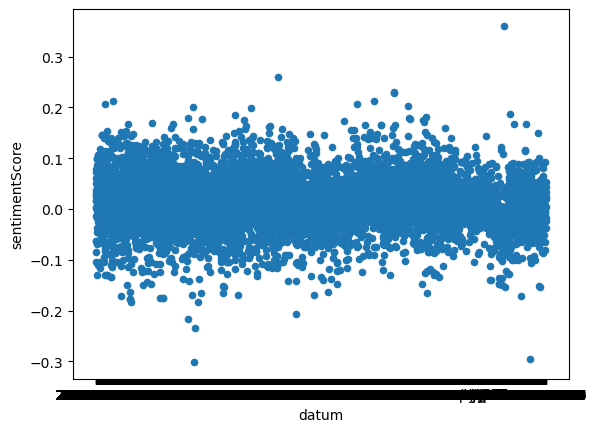

In [27]:
#getting a quick surface view of the score/time variation
speeches.plot(kind='scatter', x='datum', y='sentimentScore')
plt.show()

In [28]:
#adding a split for more specific sentiment classification
speeches.insert(7, "scoreSplit", "neutral")
speeches.loc[speeches['sentimentScore'] > 0.01, 'scoreSplit'] = 'pos'
speeches.loc[speeches['sentimentScore'] > 0.1, 'scoreSplit'] = 'strongly pos'
speeches.loc[speeches['sentimentScore'] < -0.01, 'scoreSplit'] = 'neg'
speeches.loc[speeches['sentimentScore'] < -0.1, 'scoreSplit'] = 'strongly neg'

speeches.head()

,person,datum,partei,gender,titel,position,amt,scoreSplit,url,rohtext,wordToks,wordCt,sents,sentCt,bigrams,types,sentimentScore
0,Joachim Gauck,2016-05-02,parteilos,M,Begegnungsreise mit dem Diplomatischen Korps,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,Wie viele Botschafterinnen und Botschafter hab...,"[Wie, viele, Botschafterinnen, und, Botschafte...",1653,[Wie viele Botschafterinnen und Botschafter ha...,87,"[(Wie, viele), (viele, Botschafterinnen), (Bot...","{Folge, den, rette, seien, Lösung, Denn, heißt...",0.030801
1,Joachim Gauck,2014-02-26,parteilos,M,Empfang des slowakischen Präsidenten,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,"Besuche sind eine schöne Gelegenheit, Gemeinsa...","[Besuche, sind, eine, schöne, Gelegenheit, ,, ...",833,"[Besuche sind eine schöne Gelegenheit, Gemeins...",43,"[(Besuche, sind), (sind, eine), (eine, schöne)...","{Hauptstadt, den, Monate, stehen, schönen, hei...",0.038123
2,Horst Köhler,2009-03-13,CDU,M,Grußwort von Bundespräsident Horst Köhler an d...,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,"Majestät, ich danke Ihnen für Ihre Worte des M...","[Majestät, ,, ich, danke, Ihnen, für, Ihre, Wo...",784,"[Majestät, ich danke Ihnen für Ihre Worte des ...",50,"[(Majestät, ,), (,, ich), (ich, danke), (danke...","{den, stehen, daher, begrüßen, Stelle, birgt, ...",0.016996
3,Joachim Gauck,2013-11-09,parteilos,M,Gedenkkonzert des Brandenburgischen Staatsorch...,Bundespräsident,Bundespräsident,neg,http://www.bundespraesident.de/SharedDocs/Rede...,Wir wollen heute Abend gedenken. Wir gedenken ...,"[Wir, wollen, heute, Abend, gedenken, ., Wir, ...",821,"[Wir wollen heute Abend gedenken., Wir gedenke...",32,"[(Wir, wollen), (wollen, heute), (heute, Abend...","{den, Juden, Gute, Angst, stehen, führte, dere...",-0.063073
4,Horst Köhler,2009-12-06,CDU,M,Grußwort von Bundespräsident Horst Köhler bei ...,Bundespräsident,Bundespräsident,pos,http://www.bundespraesident.de/SharedDocs/Rede...,Herzlich willkommen in Schloss Bellevue. Meine...,"[Herzlich, willkommen, in, Schloss, Bellevue, ...",1149,"[Herzlich willkommen in Schloss Bellevue., Mei...",49,"[(Herzlich, willkommen), (willkommen, in), (in...","{den, Lösung, Kurt, Stelle, Metzmacher, las, E...",0.072115


In [29]:
#looks like there arent many speeches outside of -.1 and .1
#overall more positive speeches
speeches['scoreSplit'].value_counts()

pos             3183
neg             1866
neutral         1105
strongly pos     321
strongly neg     144
Name: scoreSplit, dtype: int64

In [30]:
superPos = speeches[speeches['scoreSplit']=='strongly pos'].rohtext.tolist()
superPos[0]
#this definitely seems like a very positive speech. THe speaker starts out by saying 'it is a joy to see you here' and contunues on with other overall positive comments

'Es ist eine Freude, Sie hier zu sehen – und viele von Ihnen sehe ich ja wieder. Auch das ist mir eine Freude.\nIch liebe Dinge, die Zukunft versprechen. Und wenn ich Sie treffe, geht es immer um Ideen, um Projekte, um Vorhaben, die unserem Land nützen, die uns voranbringen. Und was ich ebenso schätze, ist, dass Menschen ihre eigene Form des Daseins als Gestalter definieren, als Verantwortliche. Und Sie wissen von mir, dass ich Verantwortung und unsere Verantwortungsfähigkeit als die schönste und angemessenste Form von Freiheit betrachte. Also gibt es gleich mehrere Gründe, warum ich mich über diese Begegnung an diesem Abend sehr freue.\nZudem kann ich bei einem Abend wie diesem die Formel vom lebenslangen Lernen auf mich selbst anwenden. Denn es ist mir bei jeder Begegnung gelungen, meinen Horizont noch ein bisschen zu erweitern, und das gedenke ich auch heute zu tun.\nWir wollen heute darüber sprechen, was Bildung und Ausbildung vermögen. Wir wollen uns den jüngsten Bildungsbericht d

In [31]:
#i'm going to take a look at the correlation between party and sentiment, but I'd like to note that the split across parties is uneven
speeches['partei'].value_counts()

CDU          3213
SPD          2250
parteilos     804
FDP           319
Grünen         33
Name: partei, dtype: int64

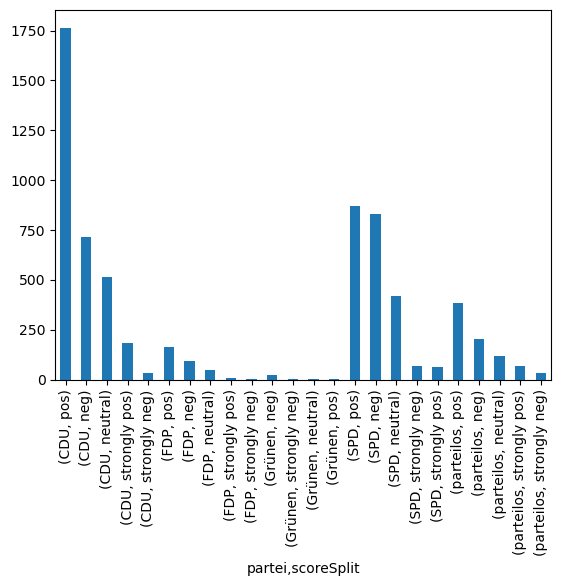

In [32]:
#this is a bit hard to compare across because of the uneven distribution so let's look at the statistical significance of the overall differences
subgroups = speeches.groupby('partei').scoreSplit.value_counts()
subgroups.plot.bar()
plt.show()

In [33]:
cdu = speeches[speeches.partei == 'CDU'].sentimentScore
fdp = speeches[speeches.partei == 'FDP'].sentimentScore
grünen = speeches[speeches.partei == 'Grünen'].sentimentScore
spd = speeches[speeches.partei == 'SPD'].sentimentScore
parteilos = speeches[speeches.partei == 'parteilos'].sentimentScore
print(stats.f_oneway(cdu, fdp, grünen, spd, parteilos))

F_onewayResult(statistic=79.44527871090574, pvalue=6.092047544277175e-66)


The overall variation isn't crazy, but the p-value shows that the differences are pretty significant. Let's see how the variation changes between 2 parties alone

In [34]:
print(stats.f_oneway(cdu, parteilos))
print(stats.f_oneway(fdp, parteilos))
print(stats.f_oneway(grünen, parteilos))
print(stats.f_oneway(spd, parteilos))

F_onewayResult(statistic=3.0279854255811687, pvalue=0.08191619275256382)
F_onewayResult(statistic=2.0295231494161734, pvalue=0.15454732745109603)
F_onewayResult(statistic=38.946286833192985, pvalue=6.921654423906375e-10)
F_onewayResult(statistic=75.11470137228382, pvalue=7.083695054236845e-18)


In [35]:
print(stats.f_oneway(cdu, fdp))
print(stats.f_oneway(cdu, grünen))
print(stats.f_oneway(cdu, spd))

F_onewayResult(statistic=9.65324090243482, pvalue=0.0019051994170114646)
F_onewayResult(statistic=66.96089450690377, pvalue=3.9340193992114156e-16)
F_onewayResult(statistic=274.273531969164, pvalue=3.815149409571216e-60)


In [36]:
print(stats.f_oneway(fdp, grünen))
print(stats.f_oneway(fdp, spd))

F_onewayResult(statistic=50.883828080968, pvalue=5.6672146413683e-12)
F_onewayResult(statistic=20.723010751038696, pvalue=5.554781003921061e-06)


In [37]:
print(stats.f_oneway(spd, grünen))

F_onewayResult(statistic=27.215060836384346, pvalue=1.9845900534114756e-07)


It looks like the CDU and SPD have the most variation in sentiment, and FDP and parteilos are the most similar.
Let's do the same look across offices(amt)

In [38]:
speeches['amt'].value_counts()

Bundesregierung        2963
Bundespräsident        2025
AuswärtigesAmt         1254
Bundestagspräsident     377
Name: amt, dtype: int64

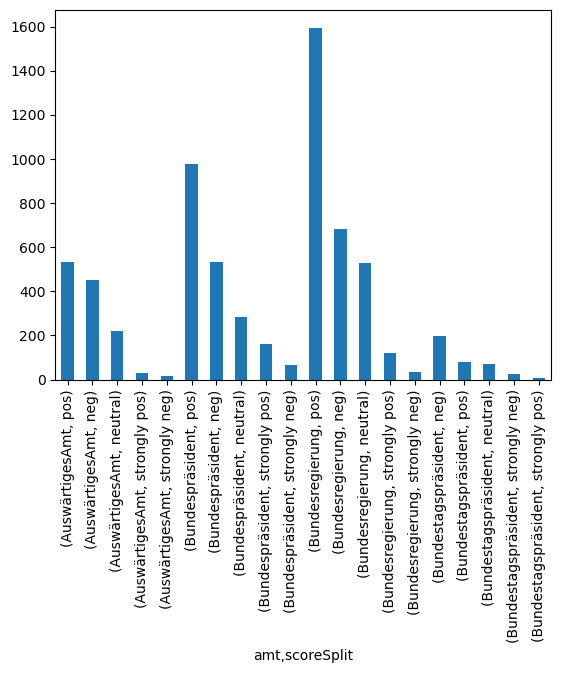

In [39]:
subgroups = speeches.groupby('amt').scoreSplit.value_counts()
subgroups.plot.bar()
plt.show()

In [40]:
aAmt = speeches[speeches.amt == 'AuswärtigesAmt'].sentimentScore
bPres = speeches[speeches.amt == 'Bundespräsident'].sentimentScore
bReg = speeches[speeches.amt == 'Bundesregierung'].sentimentScore
bTagPres = speeches[speeches.amt == 'Bundestagspräsident'].sentimentScore

print(stats.f_oneway(aAmt, bPres, bReg, bTagPres))

F_onewayResult(statistic=88.70079274501767, pvalue=2.858557120376158e-56)


In [41]:
print(stats.f_oneway(aAmt, bPres))
print(stats.f_oneway(aAmt, bReg))
print(stats.f_oneway(aAmt, bTagPres))

F_onewayResult(statistic=43.900747724345756, pvalue=4.022957762847872e-11)
F_onewayResult(statistic=84.09172288861325, pvalue=7.21587929641205e-20)
F_onewayResult(statistic=79.44372501821499, pvalue=1.2982429237621644e-18)


In [42]:
print(stats.f_oneway(bPres, bReg))
print(stats.f_oneway(bPres, bTagPres))

F_onewayResult(statistic=1.007809968452521, pvalue=0.31547679137804935)
F_onewayResult(statistic=148.6769565158858, pvalue=3.17462770726498e-33)


In [43]:
print(stats.f_oneway(bReg, bTagPres))

F_onewayResult(statistic=250.53548757710058, pvalue=1.8125040739634177e-54)


It looks like the overall variation is statistically significant. The bundesregierung and the bundestagpräsident vary the most, while the bundespräsident and bundesregierung vary the least.

### Clustering
Taking a break from sentiment analysis for some topic clustering. Trying to see how parties cluster based on the text

In [44]:
tfidf_model = TfidfVectorizer(max_features=10000, min_df=2, max_df=0.5)

x = speeches['rohtext']
y = speeches['partei']

x_tfidf = tfidf_model.fit_transform(x)

In [45]:
x_tfidf.shape

(6619, 10000)

In [46]:
svd_model = TruncatedSVD(n_components=2)         
x_svd = svd_model.fit_transform(x_tfidf)

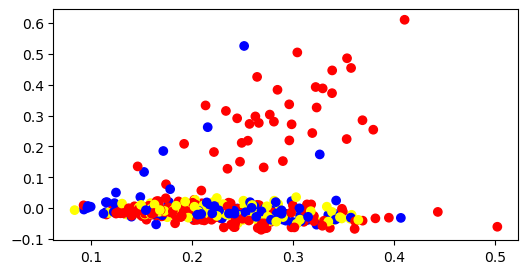

In [47]:
# Colorize this time
cdict = {'CDU':'red', 'SPD':'blue', 'Grünen':'green', 'FDP':'purple', 'parteilos':'yellow'}
colors = y.map(cdict)[:500]

plt.figure(figsize=(6,3))
plt.scatter(x_svd[:500, 0], x_svd[:500, 1], c=colors)  # let's just plot 500
plt.show()